# Excerise 5 ECN222 - estimation of a keynesian consumption equation
* Joakim Blix Prestmo
* 08.11.2018

In [71]:
import pandas as pd
#import matplotlib as plt
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [72]:
df = pd.read_excel("../MakroData.xlsx", sheet_name="Ark5")
# source: Statitics Norway and National Accounts
df_macro = pd.read_excel("http://www.ssb.no/statbank/sq/10010628/", skiprows=3, nrows=162)
# Source: KVARTS database, Statistics Norways macroeconomic model

In [73]:
df.head()

,PBOL,K83,RD300,RAM300,NB,BEF1574,NT,ntot,BF300,BG300,...,Y66,Y65,Y6,KPI,ww,YE,yei300,yei100,RENREALLONG,pbkgamma
1978-01,0.10272,1.247729e+06,30660.23088,78.5,4055.18675,2892.92766,ND,1868.51558,137245.84375,117992.60156,...,4001.10214,1840.03003,51160.40262,0.218255,40.73216,7169.00218,6879.75,688.25,G 0.00500,0.025
1978-02,0.10702,1.262613e+06,31641.81006,78.5,4059.21146,2897.92249,ND,1884.55472,139720.28125,121831.46875,...,2951.41052,1839.29358,54685.59631,0.225750,41.68868,10115.45120,6879.75,688.25,0.005,0.025
1978-03,0.11116,1.279843e+06,31853.51051,78.5,4063.28041,2902.97249,ND,1865.15321,140142.43750,124409.70313,...,3647.62540,2012.99174,57741.30455,0.240648,48.71819,16528.32300,6879.75,688.25,0.005,0.025
1978-04,0.11499,1.296472e+06,32344.44765,78.5,4067.34930,2908.05008,ND,1888.17652,147638.00000,131623.71875,...,3009.86194,2189.68465,58799.68775,0.231967,42.13985,15809.21684,6879.75,688.25,0.005,0.025
1979-01,0.11844,1.308271e+06,32802.68954,149.0,4070.19727,2912.91681,ND,1891.77716,153980.68750,132862.85938,...,3549.74414,2064.86436,57865.93527,0.230633,41.76708,13676.67289,6879.75,844.25,0.005,0.025


In [74]:
# Fix indexing
df_macro['Unnamed: 0'] = df_macro['Unnamed: 0'].str.replace('K','Q')
df_macro = df_macro.drop(['Unnamed: 0'], axis=1)
df_macro.index = pd.Index(pd.period_range('1978-01', periods=210, freq='Q'))

In [75]:
df.index = pd.Index(pd.period_range('1978-01', periods=156, freq='Q'))


# Figures


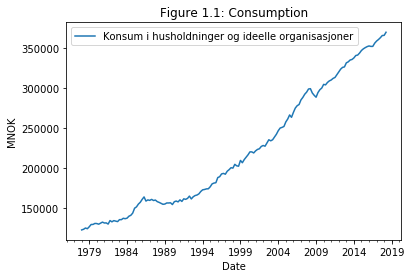

In [76]:
# Figure for household consumption
df_macro['Konsum i husholdninger og ideelle organisasjoner'].plot()
plt.title("Figure 1.1: Consumption")
plt.legend()
plt.xlabel('Date', fontdict=None, labelpad=None)
plt.ylabel('MNOK')
plt.show()


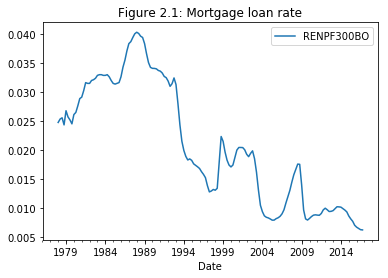

In [77]:
# Figure for mortage loan rates
df['RENPF300BO'].plot()
plt.title("Figure 2.1: Mortgage loan rate")
plt.legend()
plt.xlabel('Date', fontdict=None, labelpad=None)
plt.ylabel('')
plt.show()

In [47]:
# Merge datasets to get a complete set of data (note not the same price-set, but for our usecase this is not a big issue)
df_merge=df.merge(df_macro, how='left', on=None, left_on=None, left_index=True, right_index=True)

## Features engineering


In [81]:
# Create growth rates:
# df[log_C] = ...
df_merge['C'] = (df_merge['Konsum i husholdninger og ideelle organisasjoner'])
df_merge['c'] = np.log(df_merge['Konsum i husholdninger og ideelle organisasjoner'])
df_merge['Dc'] = np.log(df_merge['Konsum i husholdninger og ideelle organisasjoner']).diff(4)
df_merge['YD'] = (df_merge['RD300']-df_merge['RAM300'])/df_merge['KPI']
df_merge['yd'] = np.log(df_merge['YD'])
df_merge['Dyd'] = np.log(df_merge['YD']).diff(4)

df_merge['yd_1'] = np.log(df_merge['YD']).shift(1)
df_merge['c_1'] = np.log(df_merge['C']).shift(1)
df_merge['Dkpi'] = np.log(df_merge['KPI']).diff(4)

df_merge['i'] = df_merge['RENPF300BO']
df_merge['r'] = df_merge['RENPF300BO']-df_merge['Dkpi']

df_merge['Dc_1']=(df_merge['Dc']).shift(1)
df_merge['Dyd_1']=(df_merge['Dyd']).shift(1)
df_merge['Dc_2']=(df_merge['Dc_1']).shift(1)
df_merge['Dyd_2']=(df_merge['Dyd_1']).shift(1)


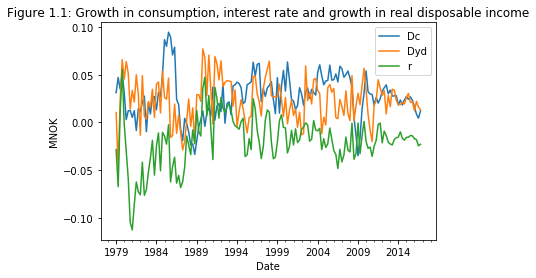

In [86]:
df_merge['Dc'].plot()
df_merge['Dyd'].plot()
df_merge['r'].plot()
plt.title("Figure 1.1: Growth in consumption, interest rate and growth in real disposable income")
plt.legend()
plt.xlabel('Date', fontdict=None, labelpad=None)
plt.ylabel('MNOK')
plt.show()

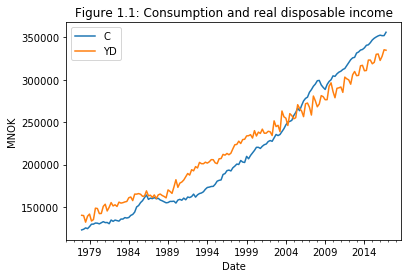

In [85]:
df_merge['C'].plot()
df_merge['YD'].plot()
plt.title("Figure 1.1: Consumption and real disposable income")
plt.legend()
plt.xlabel('Date', fontdict=None, labelpad=None)
plt.ylabel('MNOK')
plt.show()

## Build regression model

In [94]:
import statsmodels.api as sm # import statsmodels 


In [87]:
df_merge.head()

,PBOL,K83,RD300,RAM300,NB,BEF1574,NT,ntot,BF300,BG300,...,c_1,Dkpi,i,r,Dc_1,Dyd_1,Dc_2,Dyd_2,c,yd
1978Q1,0.10272,1.247729e+06,30660.23088,78.5,4055.18675,2892.92766,ND,1868.51558,137245.84375,117992.60156,...,NaN,NaN,0.02477,NaN,NaN,NaN,NaN,NaN,11.719281,11.850249
1978Q2,0.10702,1.262613e+06,31641.81006,78.5,4059.21146,2897.92249,ND,1884.55472,139720.28125,121831.46875,...,11.719281,NaN,0.02536,NaN,NaN,NaN,NaN,NaN,11.725639,11.848078
1978Q3,0.11116,1.279843e+06,31853.51051,78.5,4063.28041,2902.97249,ND,1865.15321,140142.43750,124409.70313,...,11.725639,NaN,0.02557,NaN,NaN,NaN,NaN,NaN,11.738490,11.790857
1978Q4,0.11499,1.296472e+06,32344.44765,78.5,4067.34930,2908.05008,ND,1888.17652,147638.00000,131623.71875,...,11.738490,NaN,0.02435,NaN,NaN,NaN,NaN,NaN,11.731499,11.842928
1979Q1,0.11844,1.308271e+06,32802.68954,149.0,4070.19727,2912.91681,ND,1891.77716,153980.68750,132862.85938,...,11.731499,0.055163,0.02679,-0.028373,NaN,NaN,NaN,NaN,11.750500,11.860641


In [88]:
df_merge['Dc'].shape, df_merge['Dyd'].shape

((156,), (156,))

In [89]:
# Because of the lags we want to delete the first rows
df_model = df_merge.drop(df_merge.index[[0,1,2,3,4,5]])    
df_model['Dc'].shape, df_model['Dyd'].shape

((150,), (150,))

In [90]:
#df_model[['Dyd_1', 'i']]


In [91]:
# Set up for 4 models, with increasing no of explanatory variables
modell1 = ["Dyd"]
modell2 = ["r","Dyd"]
modell3 = ["r","Dyd","yd_1", 'c_1']
modell4 = ["r","Dc_1","Dyd","Dyd_1","yd_1", 'c_1']


In [92]:
y = df_model[["Dc"]] ## X is the explanatory variables
X = df_model[modell4] ## Y is the dependent variable
X = sm.add_constant(X) ## a constant (or intercept) 
y.shape, X.shape

((150, 1), (150, 7))

In [95]:
#Regression model: fit the regression line
model = sm.OLS(y,X).fit() 


In [96]:
# Print he estimation result / model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Dc   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     34.05
Date:                Thu, 08 Nov 2018   Prob (F-statistic):           2.62e-25
Time:                        21:33:54   Log-Likelihood:                 419.45
No. Observations:                 150   AIC:                            -824.9
Df Residuals:                     143   BIC:                            -803.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1569      0.095     -1.647      0.102      -0.345       0.031
r              0.0274      0.062      0.445      0.657      -0.094       0.149
Dc_1           0.7423      0.054     13.644      0.000       0.635       0.850
Dyd            0.0182      0.077      0.238      0.812      -0.133       0.170
Dyd_1          0.0433      0.065      0.669      0.505      -0.085       0.171
yd_1           0.0541      0.029      1.863      0.064      -0.003       0.111
c_1           -0.0410      0.023     -1.794      0.075      -0.086       0.004
==============================================================================
Omnibus:                        2.578   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.276   Jarque-Bera (JB):                2.092
Skew:                          -0.248   Prob(JB):                        0.351
Kurtosis:                       3.299   Cond. No.                     1.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
# %pylab inline
# # We pick 100 hundred points equally spaced from the min to the max //create a test-set within the range of our min-max values
# X_prime = np.linspace(y.y.min(), y.y.max(), 100)[:, np.newaxis]
# X_prime = sm.add_constant(X_prime) # add constant as we did before

# # Now we calculate the predicted values
# y_hat = model.predict(X_prime)

# plt.scatter(df_merge['DC'], df_merge['DRD300'] , alpha=0.3) # Plot the raw data
# plt.xlabel("DC")
# plt.ylabel("DRD300")
# plt.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9) # Add the regression line, colored in red


# Export data

In [100]:
datalist = ['C', 'c', 'c_1', 'Dc', 'Dc_1', 'r', 'i', 'YD','yd', 'yd_1', 'Dyd_1']

In [101]:
df_short = df_model[datalist]
df_short.to_excel("../MakroDataKort.xlsx")

In [102]:
df_model.to_excel("../MakroDataModell.xlsx")

In [103]:
df_short.head()

,C,c,c_1,Dc,Dc_1,r,i,YD,yd,yd_1,Dyd_1
1979Q3,129761.0,11.773450,11.772810,0.034959,0.047171,0.011346,0.02521,135136.333506,11.814039,11.801166,-0.046912
1979Q4,131001.0,11.782960,11.773450,0.051462,0.034959,0.055451,0.02453,148549.550825,11.908674,11.814039,0.023183
1980Q1,130856.0,11.781853,11.782960,0.031352,0.051462,-0.001258,0.02613,148175.988015,11.906156,11.908674,0.065746
1980Q2,130062.0,11.775767,11.781853,0.002957,0.031352,-0.030648,0.02650,142179.997387,11.864849,11.906156,0.045515
1980Q3,131344.0,11.785575,11.775767,0.012126,0.002957,-0.058704,0.02763,142300.418000,11.865696,11.864849,0.063683
